In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import copy
import math
from astropy.modeling import models
from specutils.fitting import fit_lines
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.spectra import Spectrum1D
from astropy import units as u
from astropy.modeling.fitting import LinearLSQFitter, SimplexLSQFitter, SLSQPLSQFitter, LevMarLSQFitter
from specutils import Spectrum1D, SpectralRegion, fitting, analysis, manipulation
from scipy import integrate, optimize, interpolate
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve
from astropy.modeling import models, polynomial
import pandas as pd
import csv
import json

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\csuzd\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['convolve', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## HRD from Gaia distance values

In [2]:
with open('1697456835684O-result.json') as file:
  contents = json.loads(file.read())
  
metadata = contents["metadata"]
data = contents["data"]
print(len(data))
for i in range(len(metadata)):
    print("{}. {}: {}, unit: {}".format(i, metadata[i]["name"], metadata[i]["description"], metadata[i]["unit"]))

169899
0. source_id: Unique source identifier (unique within a particular Data Release), unit: None
1. parallax: Parallax, unit: mas
2. phot_g_mean_mag: G-band mean magnitude, unit: mag
3. teff_gspphot: Effective temperature from GSP-Phot Aeneas best library using BP/RP spectra, unit: K
4. distance_gspphot: Distance from GSP-Phot Aeneas best library using BP/RP spectra, unit: pc


In [3]:
def extractColumn(data: list, columnIndex: int):
    return np.array(list(map(lambda x: x[columnIndex], data)))

data = list(filter(lambda x: x[1] and x[2] and x[3] and x[4], data))

T = extractColumn(data, 3)
m = extractColumn(data, 2)
d = extractColumn(data, 4)
p = extractColumn(data, 1)
M = m - 5 * np.log10(d) + 5

In [4]:
L0=3.0128*10**28 # Watt
M0=4.38

L_L0=[]

L=L0*(10**(M0-M/2.512))
L_L0 = np.array(np.log10(L/L0))

C:\Users\csuzd\AppData\Local\Temp/ipykernel_22108/2266400951.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([-1.5,-1,0,1,2,3,4,5],fontsize=13)
C:\Users\csuzd\AppData\Local\Temp/ipykernel_22108/2266400951.py:35: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(aspect=30, orientation='horizontal',pad=0.0)


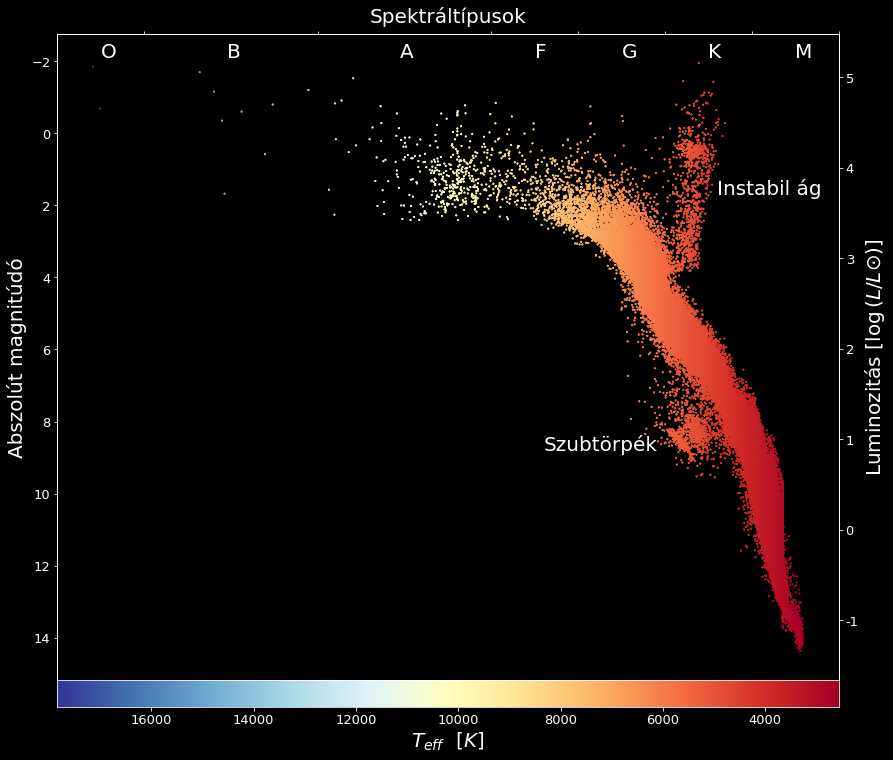

In [6]:
plt.figure(figsize = (14, 14))
plt.style.use('dark_background')

plt.ylabel('Abszolút magnitúdó',fontsize=20)
plt.xticks(fontsize=13,color='black')
plt.yticks(fontsize=13)

plt.scatter(T,M,s=1,c=T,cmap='RdYlBu')

ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()

ax2 = ax.twinx()
ax2.scatter(T,L_L0,s=1,c=T,cmap='RdYlBu')
ax2.set_ylabel('Luminozitás [$\log{(L/L{\odot})}$]',fontsize=20)
ax2.set_yticklabels([-1.5,-1,0,1,2,3,4,5],fontsize=13)

ax3 = ax.twiny()
ax3.set_xticks((1,3,5,6,7,8,9))
ax3.set_xticklabels(['','','','','','',''],fontsize=16)
ax3.set_xlabel('Spektráltípusok',fontsize=20)

plt.text(0.5,-2.1,'O',fontsize=20)
plt.text(1.95,-2.1,'B',fontsize=20)
plt.text(3.95,-2.1,'A',fontsize=20)
plt.text(5.5,-2.1,'F',fontsize=20)
plt.text(6.5,-2.1,'G',fontsize=20)
plt.text(7.5,-2.1,'K',fontsize=20)
plt.text(8.5,-2.1,'M',fontsize=20)

plt.text(7.6,1.7,'Instabil ág',fontsize=20)
plt.text(5.6,8.8,'Szubtörpék',fontsize=20)

clb = plt.colorbar(aspect=30, orientation='horizontal',pad=0.0)
clb.ax.invert_xaxis()
clb.set_label('$T_{eff}~~ [K]$',fontsize=20)
clb.ax.tick_params(labelsize=13)

show()

## HRD from distance values calculated from Gaia parallax values

In [7]:
d1 = (1/p)*1000
M1 = m - 5 * np.log10(d1) + 5
L0=3.0128*10**28 # Watt
M0=4.38

L_L0=[]

L=L0*(10**(M0-M1/2.512))
L_L0 = np.array(np.log10(L/L0))

C:\Users\csuzd\AppData\Local\Temp/ipykernel_22108/2808086289.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([-1.5,-1,0,1,2,3,4,5],fontsize=13)
C:\Users\csuzd\AppData\Local\Temp/ipykernel_22108/2808086289.py:35: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  clb = plt.colorbar(aspect=30, orientation='horizontal',pad=0.0)


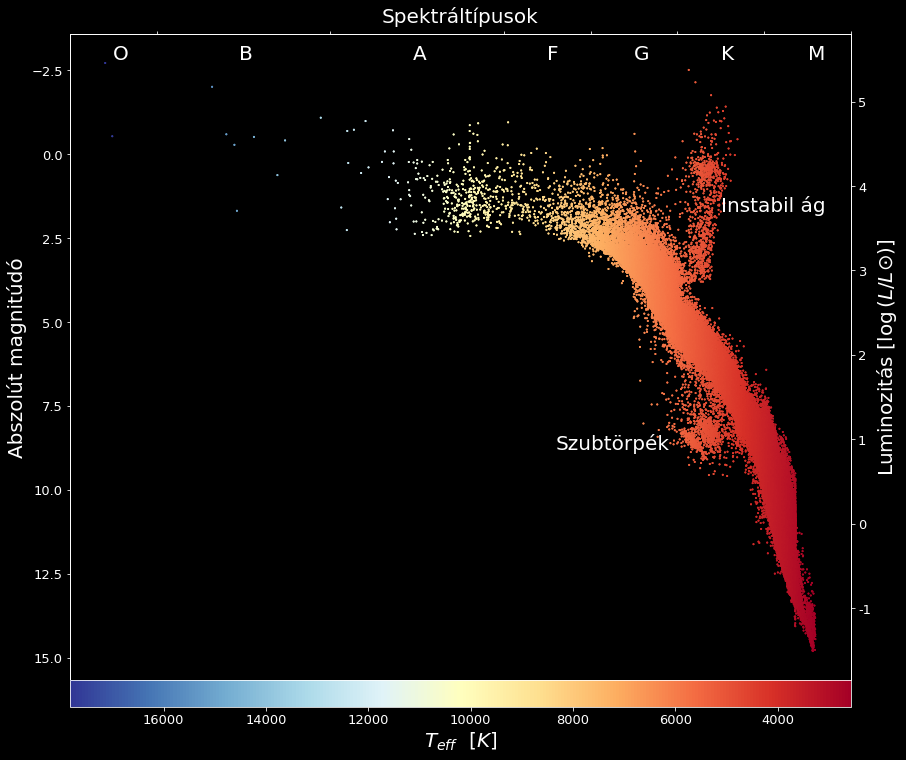

In [8]:
plt.figure(figsize = (14, 14))
plt.style.use('dark_background')

plt.ylabel('Abszolút magnitúdó',fontsize=20)
plt.xticks(fontsize=13,color='black')
plt.yticks(fontsize=13)

plt.scatter(T,M1,s=1,c=T,cmap='RdYlBu')

ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()

ax2 = ax.twinx()
ax2.scatter(T,L_L0,s=1,c=T,cmap='RdYlBu')
ax2.set_ylabel('Luminozitás [$\log{(L/L{\odot})}$]',fontsize=20)
ax2.set_yticklabels([-1.5,-1,0,1,2,3,4,5],fontsize=13)

ax3 = ax.twiny()
ax3.set_xticks((1,3,5,6,7,8,9))
ax3.set_xticklabels(['','','','','','',''],fontsize=16)
ax3.set_xlabel('Spektráltípusok',fontsize=20)

plt.text(0.5,-2.8,'O',fontsize=20)
plt.text(1.95,-2.8,'B',fontsize=20)
plt.text(3.95,-2.8,'A',fontsize=20)
plt.text(5.5,-2.8,'F',fontsize=20)
plt.text(6.5,-2.8,'G',fontsize=20)
plt.text(7.5,-2.8,'K',fontsize=20)
plt.text(8.5,-2.8,'M',fontsize=20)

plt.text(7.5,1.7,'Instabil ág',fontsize=20)
plt.text(5.6,8.8,'Szubtörpék',fontsize=20)

clb = plt.colorbar(aspect=30, orientation='horizontal',pad=0.0)
clb.ax.invert_xaxis()
clb.set_label('$T_{eff}~~ [K]$',fontsize=20)
clb.ax.tick_params(labelsize=13)

show()